In [1]:
cd ../..

/userdata/jgauthier/projects/ideal-word-representations


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from pathlib import Path
import pickle

In [138]:
feature_selection_paths = list(Path("outputs/synthetic_encoders").glob("**/forward_selection.pkl"))
feature_selection_paths

[PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic10/multisyllabic/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic10/monosyllabic/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic10/multisyllabic-nonfirst_syllable/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic10/all/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic128/multisyllabic-nonfirst_syllable/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic128/monosyllabic/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic128/multisyllabic/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic128/all/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic50/all/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_2/basic50/monosyllabic/forward_selection.pkl'),
 Po

In [139]:
feature_selection_results = {}
for path in feature_selection_paths:
    with open(path, "rb") as f:
        key = (path.parent.name, path.parents[1].name, path.parents[2].name)
        result = pickle.load(f)
        feature_selection_results[key] = {"spec_trajectory": result["spec_trajectory"], "score_trajectory": result["score_trajectory"]}

In [140]:
score_df = pd.DataFrame([feature_selection_results[key]["score_trajectory"] for key in feature_selection_results],
                        index=pd.MultiIndex.from_tuples(feature_selection_results.keys(), names=["subsample_strategy", "encoder", "base_model"])) \
                            .reset_index().melt(id_vars=["subsample_strategy", "encoder", "base_model"], var_name="step", value_name="score")
score_df

,subsample_strategy,encoder,base_model,step,score
0,multisyllabic,basic10,w2v2_2,0,-inf
1,monosyllabic,basic10,w2v2_2,0,-inf
2,multisyllabic-nonfirst_syllable,basic10,w2v2_2,0,-inf
3,all,basic10,w2v2_2,0,-inf
4,multisyllabic-nonfirst_syllable,basic128,w2v2_2,0,-inf
...,...,...,...,...,...
1255,multisyllabic,basic128,w2v2-large_20,6,0.061848
1256,monosyllabic,basic50,w2v2-large_20,6,0.116360
1257,all,basic50,w2v2-large_20,6,0.116676
1258,multisyllabic-nonfirst_syllable,basic50,w2v2-large_20,6,0.116229


In [141]:
selection_df = pd.DataFrame([[traj[-1] if len(traj) > 0 else None
                            for traj in feature_selection_results[key]["spec_trajectory"]]
                            for key in feature_selection_results],
                            index=pd.MultiIndex.from_tuples(feature_selection_results.keys(), names=["subsample_strategy", "encoder", "base_model"])).reset_index() \
    .melt(id_vars=["subsample_strategy", "encoder", "base_model"], var_name="step", value_name="selected_embedding") \
    .dropna()
selection_df

,subsample_strategy,encoder,base_model,step,selected_embedding
180,multisyllabic,basic10,w2v2_2,1,biphone_pred
181,monosyllabic,basic10,w2v2_2,1,biphone_pred
182,multisyllabic-nonfirst_syllable,basic10,w2v2_2,1,biphone_pred
183,all,basic10,w2v2_2,1,biphone_pred
184,multisyllabic-nonfirst_syllable,basic128,w2v2_2,1,biphone_pred
...,...,...,...,...,...
1255,multisyllabic,basic128,w2v2-large_20,6,next_phoneme
1256,monosyllabic,basic50,w2v2-large_20,6,next_phoneme
1257,all,basic50,w2v2-large_20,6,next_phoneme
1258,multisyllabic-nonfirst_syllable,basic50,w2v2-large_20,6,next_phoneme


In [142]:
merged_df = score_df.merge(selection_df, on=["subsample_strategy", "encoder", "base_model", "step"]).set_index(["subsample_strategy", "encoder", "base_model", "step"]).sort_index()
merged_df["improvement"] = merged_df.score.diff()
merged_df.loc[merged_df.index.get_level_values("step") == 1, "improvement"] = merged_df.loc[merged_df.index.get_level_values("step") == 1, "score"]
merged_df = merged_df.reset_index()
merged_df["base_model_class"] = merged_df.base_model.str.rsplit("_", n=1).str[0]
merged_df["base_model_layer"] = merged_df.base_model.str.rsplit("_", n=1).str[-1].astype(int)

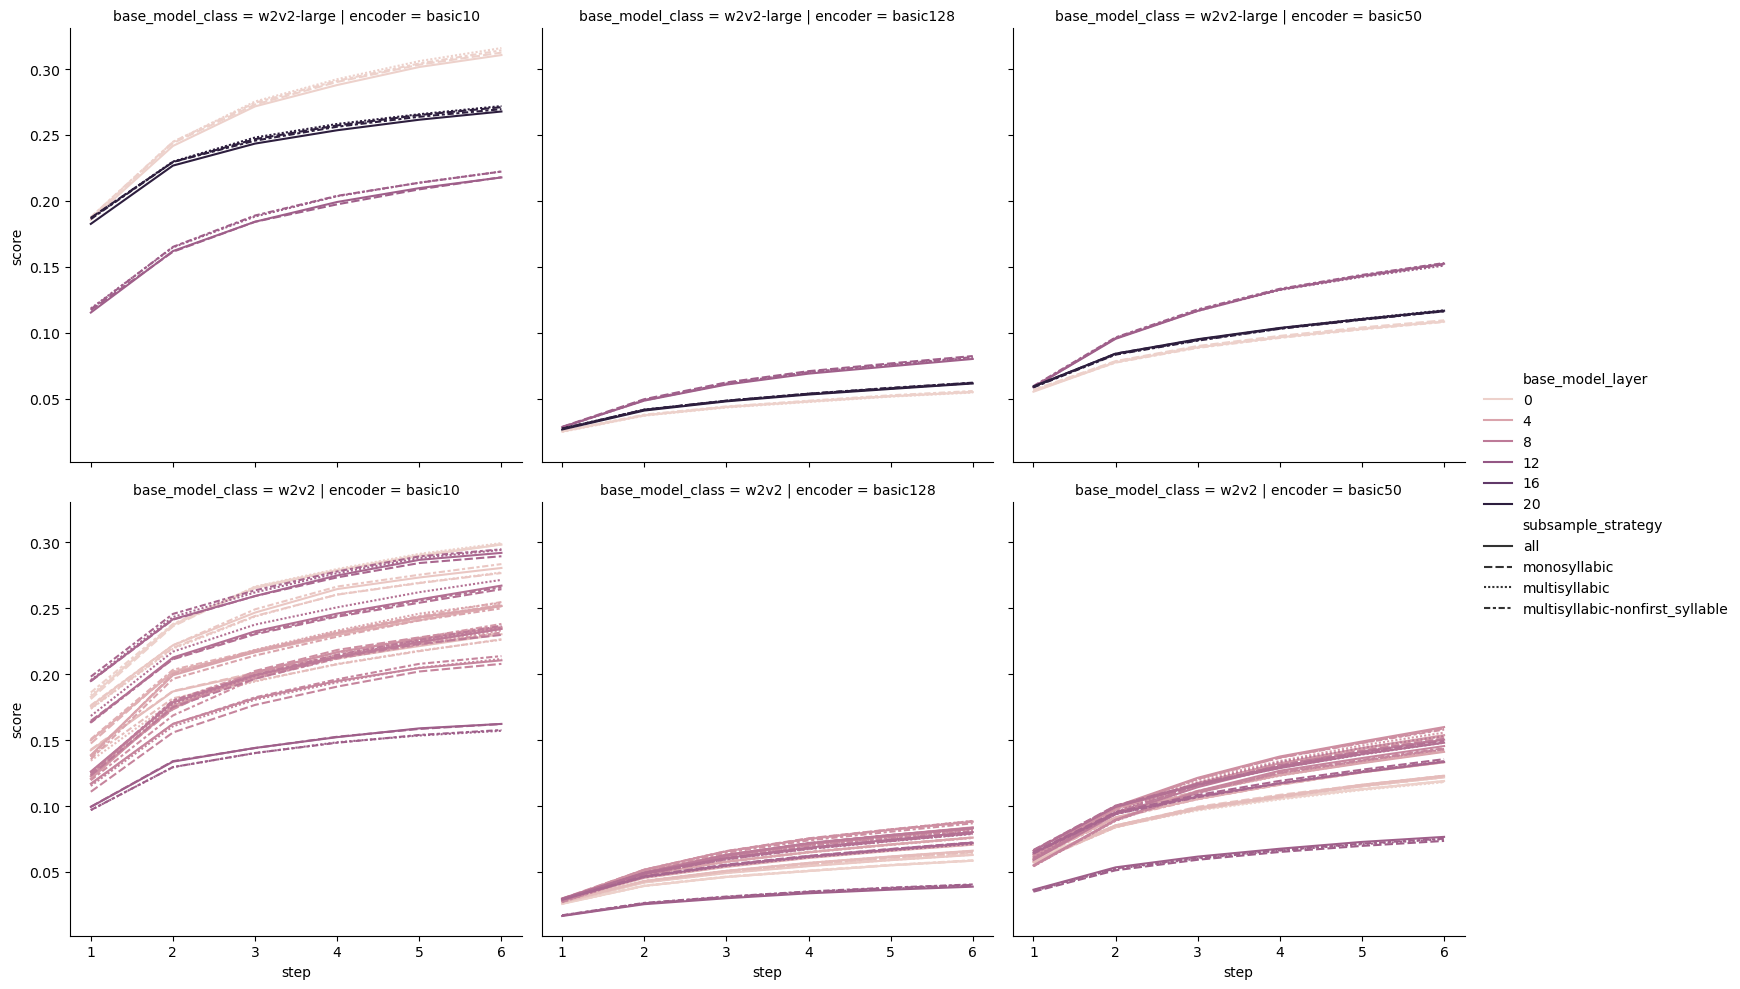

In [143]:
merged_df.pipe((sns.relplot, "data"), x="step", y="score", row="base_model_class", col="encoder",
               hue="base_model_layer", style="subsample_strategy", kind="line")

In [144]:
stack_plot_colors = {emb: color for emb, color in zip(merged_df.selected_embedding.unique(), sns.color_palette())}
stack_plot_panels = [
    (target_model_class, encoder, strategy)
    for target_model_class in ["w2v2", "w2v2-large"]
    for encoder in ["basic10", "basic50", "basic128"]
    for strategy in ["all", "multisyllabic", "monosyllabic", "multisyllabic-nonfirst_syllable"]
]

In [145]:
merged_df["base_model_and_encoder"] = merged_df.base_model_class + "_" + merged_df.encoder

In [146]:
merged_df

,subsample_strategy,encoder,base_model,step,score,selected_embedding,improvement,base_model_class,base_model_layer,base_model_and_encoder
0,all,basic10,w2v2-large_0,1,0.185588,biphone_pred,0.185588,w2v2-large,0,w2v2-large_basic10
1,all,basic10,w2v2-large_0,2,0.241670,biphone_recon,0.056082,w2v2-large,0,w2v2-large_basic10
2,all,basic10,w2v2-large_0,3,0.271685,word_broad,0.030015,w2v2-large,0,w2v2-large_basic10
3,all,basic10,w2v2-large_0,4,0.287908,phoneme,0.016223,w2v2-large,0,w2v2-large_basic10
4,all,basic10,w2v2-large_0,5,0.301565,next_phoneme,0.013657,w2v2-large,0,w2v2-large_basic10
...,...,...,...,...,...,...,...,...,...,...
1075,multisyllabic-nonfirst_syllable,basic50,w2v2_9,2,0.100022,biphone_recon,0.033620,w2v2,9,w2v2_basic50
1076,multisyllabic-nonfirst_syllable,basic50,w2v2_9,3,0.116795,syllable,0.016773,w2v2,9,w2v2_basic50
1077,multisyllabic-nonfirst_syllable,basic50,w2v2_9,4,0.129637,word_broad,0.012842,w2v2,9,w2v2_basic50
1078,multisyllabic-nonfirst_syllable,basic50,w2v2_9,5,0.139726,next_phoneme,0.010088,w2v2,9,w2v2_basic50


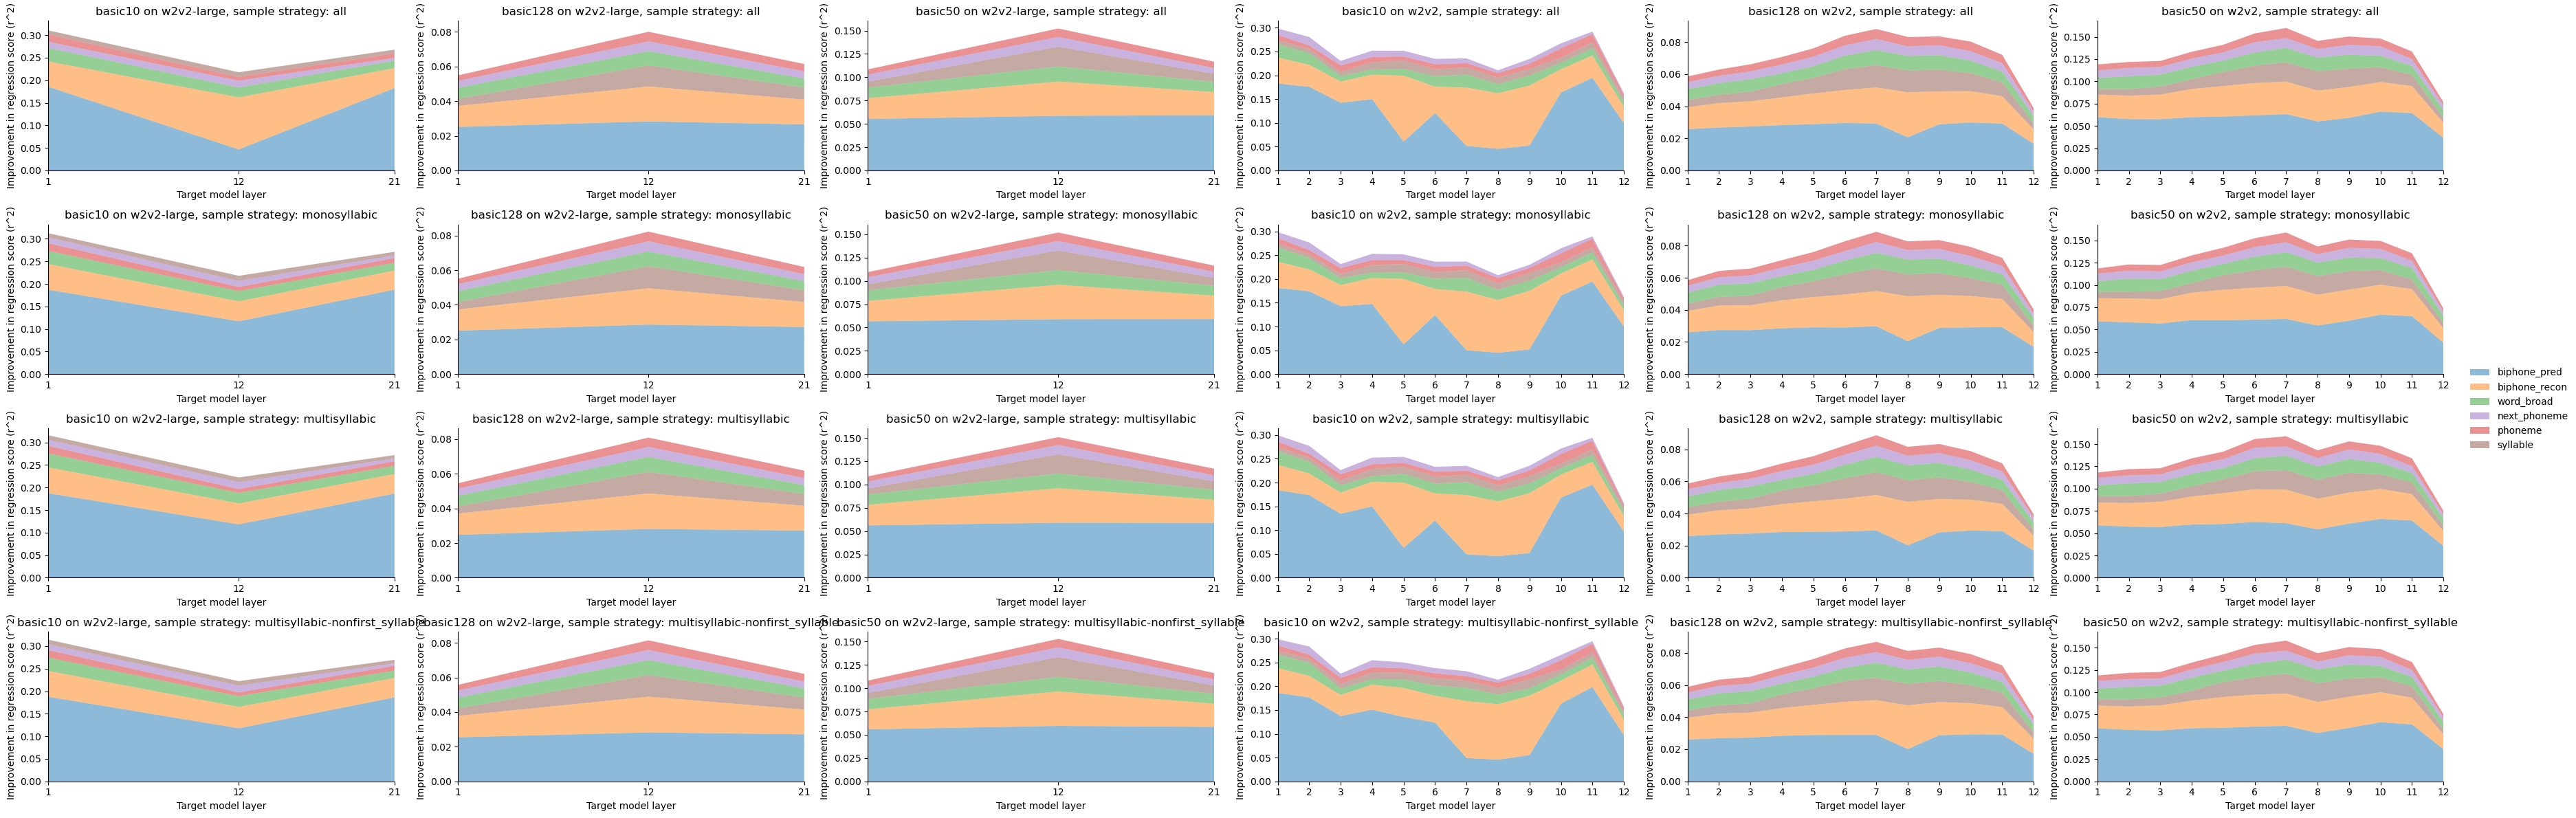

In [147]:
def plot_stackplot(data, **kws):
    ax = plt.gca()
    plot_df = data.sort_values("base_model_layer").pivot_table(index="base_model_layer", columns="selected_embedding", values="improvement").fillna(0)
    # Reorder columns based on mean explained variance
    column_order = plot_df.mean().sort_values(ascending=False).index
    plot_df = plot_df[column_order]
    ax.stackplot(plot_df.index, plot_df.T, labels=plot_df.columns,
                 colors=[stack_plot_colors[emb] for emb in plot_df.columns], alpha=0.5)
    
    encoder = data.encoder.iloc[0]
    base_model_class = data.base_model_class.iloc[0]
    strategy = data.subsample_strategy.iloc[0]
    ax.set_title(f"{encoder} on {base_model_class}, sample strategy: {strategy}")
    ax.set_xlim((plot_df.index.min(), plot_df.index.max()))
    ax.set_xticks(plot_df.index)
    ax.set_xticklabels(1 + plot_df.index)
    ax.set_xlabel("Target model layer")
    ax.set_ylabel("Improvement in regression score (r^2)")
    ax.legend(title="Feature / embedding", loc="center left", bbox_to_anchor=(1, 0.5))

g = sns.FacetGrid(data=merged_df,
                  col="base_model_and_encoder", col_order=sorted(merged_df.base_model_and_encoder.unique()),
                  row="subsample_strategy",
                  sharex=False, sharey="col", aspect=2)
g.map_dataframe(plot_stackplot)
g.add_legend()

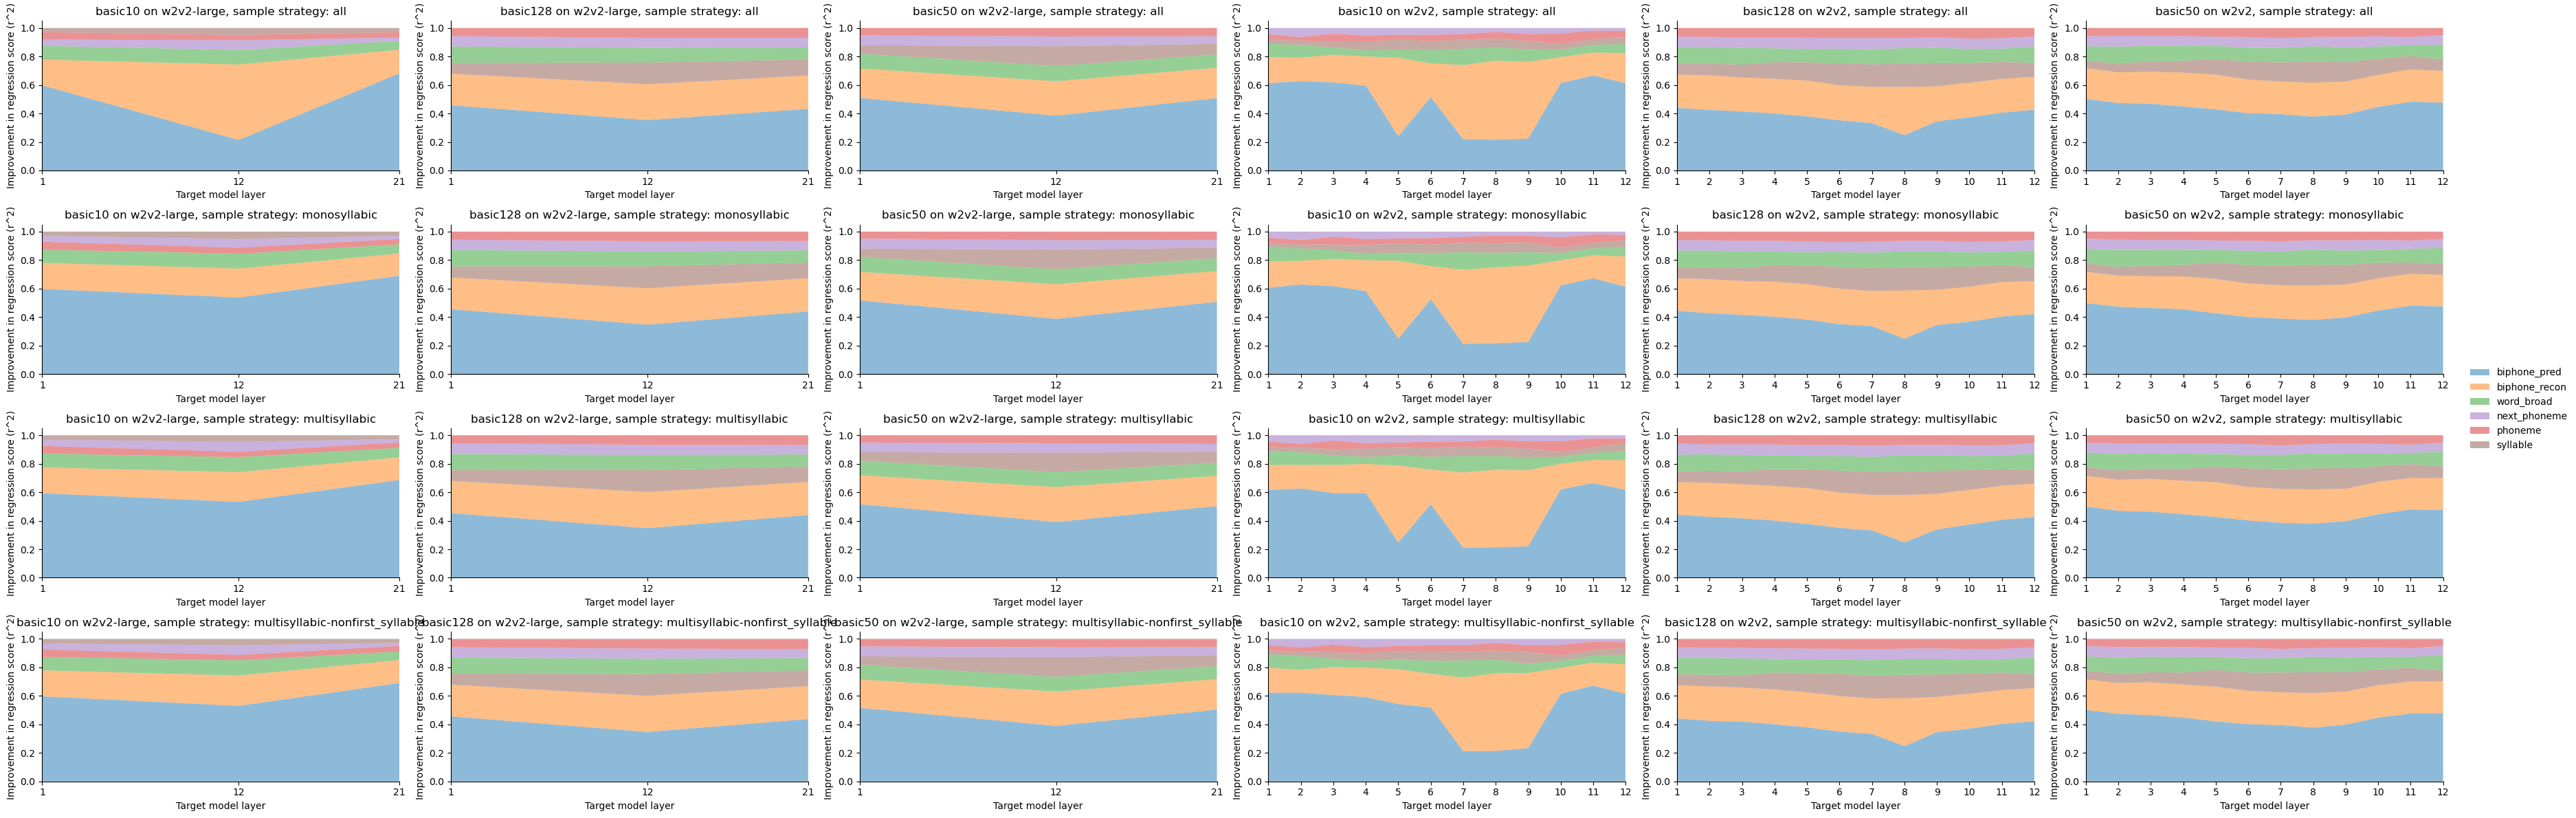

In [150]:
def plot_stackplot(data, **kws):
    ax = plt.gca()
    plot_df = data.sort_values("base_model_layer").pivot_table(index="base_model_layer", columns="selected_embedding", values="improvement").fillna(0)
    # Reorder columns based on mean explained variance
    column_order = plot_df.mean().sort_values(ascending=False).index
    plot_df = plot_df[column_order]
    # Normalize by total variance explained at each layer
    plot_df = plot_df.divide(plot_df.sum(axis=1), axis=0)
    ax.stackplot(plot_df.index, plot_df.T, labels=plot_df.columns,
                 colors=[stack_plot_colors[emb] for emb in plot_df.columns], alpha=0.5)
    
    encoder = data.encoder.iloc[0]
    base_model_class = data.base_model_class.iloc[0]
    strategy = data.subsample_strategy.iloc[0]
    ax.set_title(f"{encoder} on {base_model_class}, sample strategy: {strategy}")
    ax.set_xlim((plot_df.index.min(), plot_df.index.max()))
    ax.set_xticks(plot_df.index)
    ax.set_xticklabels(1 + plot_df.index)
    ax.set_xlabel("Target model layer")
    ax.set_ylabel("Improvement in regression score (r^2)")
    ax.legend(title="Feature / embedding", loc="center left", bbox_to_anchor=(1, 0.5))

g = sns.FacetGrid(data=merged_df,
                  col="base_model_and_encoder", col_order=sorted(merged_df.base_model_and_encoder.unique()),
                  row="subsample_strategy",
                  sharex=False, sharey="col", aspect=2)
g.map_dataframe(plot_stackplot)
g.add_legend()

## Sankey

In [148]:
selection_df

,subsample_strategy,encoder,base_model,step,selected_embedding
180,multisyllabic,basic10,w2v2_2,1,biphone_pred
181,monosyllabic,basic10,w2v2_2,1,biphone_pred
182,multisyllabic-nonfirst_syllable,basic10,w2v2_2,1,biphone_pred
183,all,basic10,w2v2_2,1,biphone_pred
184,multisyllabic-nonfirst_syllable,basic128,w2v2_2,1,biphone_pred
...,...,...,...,...,...
1255,multisyllabic,basic128,w2v2-large_20,6,next_phoneme
1256,monosyllabic,basic50,w2v2-large_20,6,next_phoneme
1257,all,basic50,w2v2-large_20,6,next_phoneme
1258,multisyllabic-nonfirst_syllable,basic50,w2v2-large_20,6,next_phoneme


In [149]:
from ipysankeywidget import SankeyWidget

links = []
for group, rows in selection_df.groupby(["base_model", "encoder"]):
    for i, (e1, e2) in enumerate(zip(rows.selected_embedding, rows.selected_embedding[1:])):
        links.append({"source": e1, "target": e2, "value": 1 * (i + 1), "type": str(group)})

SankeyWidget(links=links)

ValueError: Links has at least one duplicated entry. The first duplicated item appears at index 1. See https://github.com/ricklupton/ipysankeywidget/issues/22